<a href="https://colab.research.google.com/github/MattiaPOLI/DR14/blob/nico/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ~-----enable Colab to load CSV-----
# import useful libraries
from google.colab import files

# specify the file to load
uploaded = files.upload()

Saving Sky.csv to Sky.csv


In [0]:
# ~-----setup matplotlib-----
# auxiliary variables
import IPython
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff

# allow plotly to operate
def enable_plotly_in_cell():
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  plotly.offline.init_notebook_mode(connected=True)

In [15]:
# ~-----import libraries-----
import pandas as pd
import numpy as np
import io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# ~-----load desired data-----
# store data in a Pandas dataframe
df = pd.read_csv(io.StringIO(uploaded['Sky.csv'].decode('utf-8')), sep=',', header=0)


# ~-----data cleaning-----
# drop the following useless features:
#   - objid, specobjid: numerical ID of the celestial body
#   - run, rerun, camcol, field: parameters used to identify from which scan data are taken
#   - plate, mjd, fiberid: parameters related to the used laboratory equipment
df_cleaned = df.drop( columns=['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'plate', 'mjd', 'fiberid'] )

# remove missing values
df_cleaned = df_cleaned.dropna()


# ~-----retrieve predictors and response variables-----
# get predictors
X = df_cleaned

# extract class label from the dataframe
y = X.pop('class')

# determine available classes
classes = np.unique(y.values).tolist()
class_code = {classes[k]: k for k in range(3)}
y_colors = [class_code[cl] for cl in y]


# ~-----normalize data-----
# create standard scaler object
scaler = StandardScaler().fit(X)

# normalize predictors
X_norm = scaler.transform(X)


# ~-----PCA-----
# create PCA object
pca = PCA().fit(X_norm)

# find new space
X_pca = pca.transform(X_norm)

# exploit most expressive PCs (first 5)
X_ready = X_pca[:, 0:5]


# ~-----visualize results-----
print (class_code)

print ('X= ' + str(X_ready.shape))
print ('y= ' + str(y.shape))

X_ready.view()
pd.DataFrame(X_ready).head(5)

{'GALAXY': 0, 'QSO': 1, 'STAR': 2}
X= (10000, 5)
y= (10000,)


,0,1,2,3,4
0,-1.152398,-0.665390,-0.332349,-0.673543,-1.368384
1,-0.280886,-0.580659,-0.318863,-0.162143,0.079136
2,1.302004,-0.712858,-0.294070,-0.401561,-0.374463
3,-1.559333,-0.373053,-0.343074,0.380661,0.519273
4,-1.207519,-0.336505,-0.337798,0.606273,1.213936


In [0]:
# ~-----import libraries-----
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn


# ~-----create training and testing sets-----
X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.3, random_state=42)


# ~-----generally valid variables-----
C_range = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
gamma_range = np.array([1e-9, 1e-7, 1e-5, 1e-3])

======= Linear SVM =======
C=0.001   	--> 77.32%
C=0.01   	--> 85.34%
C=0.1   	--> 95.20%
C=1.0   	--> 97.83%
C=10.0   	--> 98.26%
C=100.0   	--> 98.29%
C=1000.0   	--> 98.33%

Best C=   	1000.0


No handles with labels found to put in legend.


Test accuracy= 	98.20%


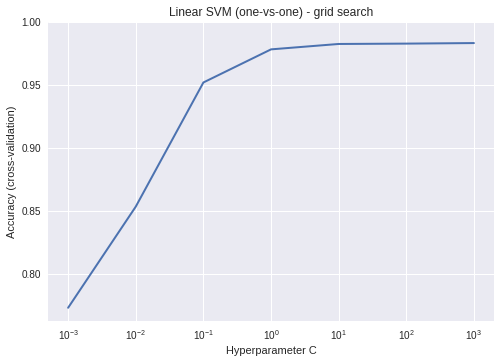

In [10]:
# ~-----linear SVM (one-vs-one)-----
# auxiliary variables
accuracy_validation = []
score_max = 0
C_best_linear = 0

# optimizes parameters
print("======= Linear SVM =======")
for C in C_range:
    model = svm.SVC(kernel='linear', C=C)
    scores = cross_val_score(model, X_train, y_train, cv=10)
    avg = np.mean(scores)
    accuracy_validation.append(avg)
    print("C=" + str(C) + "   \t--> %.2f%%" % (avg*100))
    if (avg > score_max):
        score_max = avg
        C_best_linear = C
            
print("\nBest C=   \t" + str(C_best_linear))


# ~-----create best SVM-----
# train model
svc_linear_one = svm.SVC(kernel='linear', C=C_best_linear)
svc_linear_one.fit(X_train, y_train)

# evaluate classificator on testing set
accuracy = svc_linear_one.score(X_test, y_test)

print("Test accuracy= \t%.2f%%" % (accuracy*100))


# ~-----visualize results-----
# accuracy w.r.t. parameters
fig = plt.figure()
ax = fig.gca()
plt.plot(C_range, accuracy_validation, linewidth=2)#, label='average accuracy on cross validation')
plt.xscale("log")
plt.ylim(top=1)
plt.title('Linear SVM (one-vs-one) - grid search')
plt.xlabel('Hyperparameter C')
plt.ylabel('Accuracy (cross-validation)')
ax.legend()
plt.show()

# TODO: decision boundaries


In [13]:
# ~-----confusion matrix-----
# compute confusion matrix
y_pred = svc_linear_one.predict(X_test)
conf_mtx = confusion_matrix(y_test, y_pred)

# plot confusion matrix
for j in range(3):
  conf_mtx[0][j], conf_mtx[2][j] = conf_mtx[2][j], conf_mtx[0][j]
conf_mtx = np.ndarray.round(conf_mtx.astype(float) / conf_mtx.sum(axis = 1)[:, np.newaxis], 3)

cmColorScale = [[0.0, "rgb(255, 255, 255)"], [1.0, "rgb(0, 0, 255)"]]

z = conf_mtx
x = ["Galaxy", "QSO", "Star"]
y = ["Star", "QSO", "Galaxy"]
figure = ff.create_annotated_heatmap(z, x = x, y = y, colorscale= cmColorScale, showscale = True)
figure['layout']['xaxis']['title']['text'] = "Predicted Label"
figure['layout']['xaxis']['side'] = "bottom"
figure['layout']['yaxis']['title']['text'] = "True Label"
figure['layout']['title'] = "Linear SVM (one-vs-one) - confusion matrix"
enable_plotly_in_cell()
plotly.offline.iplot(figure, filename="rbfAccuracy") 

======= Linear SVM =======
C=0.001   	--> 79.49%
C=0.01   	--> 86.44%
C=0.1   	--> 93.17%
C=1.0   	--> 96.43%
C=10.0   	--> 97.60%
C=100.0   	--> 97.74%


No handles with labels found to put in legend.


C=1000.0   	--> 97.76%

Best C=   	1000.0
Test accuracy= 	97.57%


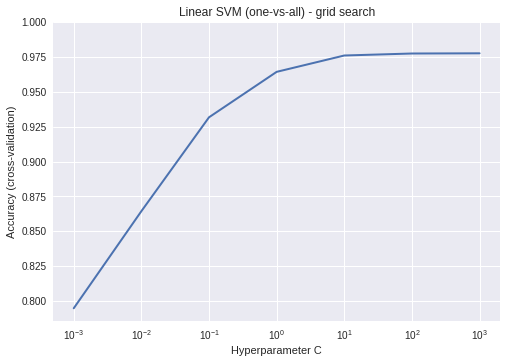

In [17]:
# ~-----linear SVM (one-vs-all)-----
# auxiliary variables
accuracy_validation = []
score_max = 0
C_best_linear = 0

# optimizes parameters
print("======= Linear SVM =======")
for C in C_range:
    model = svm.LinearSVC(C=C, dual=False)
    scores = cross_val_score(model, X_train, y_train, cv=10)
    avg = np.mean(scores)
    accuracy_validation.append(avg)
    print("C=" + str(C) + "   \t--> %.2f%%" % (avg*100))
    if (avg > score_max):
        score_max = avg
        C_best_linear = C
            
print("\nBest C=   \t" + str(C_best_linear))


# ~-----create best SVM-----
# train model
svc_linear_all = svm.LinearSVC(C=C_best_linear, dual=False)
svc_linear_all.fit(X_train, y_train)

# evaluate classificator on testing set
accuracy = svc_linear_all.score(X_test, y_test)

print("Test accuracy= \t%.2f%%" % (accuracy*100))


# ~-----visualize results-----
# accuracy w.r.t. parameters
fig = plt.figure()
ax = fig.gca()
plt.plot(C_range, accuracy_validation, linewidth=2)#, label='average accuracy on cross validation')
plt.xscale("log")
plt.ylim(top=1)
plt.title('Linear SVM (one-vs-all) - grid search')
plt.xlabel('Hyperparameter C')
plt.ylabel('Accuracy (cross-validation)')
ax.legend()
plt.show()

# TODO: decision boundaries

In [18]:
# ~-----confusion matrix-----
# compute confusion matrix
y_pred = svc_linear_all.predict(X_test)
conf_mtx = confusion_matrix(y_test, y_pred)

# plot confusion matrix
for j in range(3):
  conf_mtx[0][j], conf_mtx[2][j] = conf_mtx[2][j], conf_mtx[0][j]
conf_mtx = np.ndarray.round(conf_mtx.astype(float) / conf_mtx.sum(axis = 1)[:, np.newaxis], 3)

cmColorScale = [[0.0, "rgb(255, 255, 255)"], [1.0, "rgb(0, 0, 255)"]]

z = conf_mtx
x = ["Galaxy", "QSO", "Star"]
y = ["Star", "QSO", "Galaxy"]
figure = ff.create_annotated_heatmap(z, x = x, y = y, colorscale= cmColorScale, showscale = True)
figure['layout']['xaxis']['title']['text'] = "Predicted Label"
figure['layout']['xaxis']['side'] = "bottom"
figure['layout']['yaxis']['title']['text'] = "True Label"
figure['layout']['title'] = "Linear SVM (one-vs-all) - confusion matrix"
enable_plotly_in_cell()
plotly.offline.iplot(figure, filename="rbfAccuracy") 

============ RBF SVM ============
C=0.001   	gamma=1e-09   	--> 50.01%
C=0.001   	gamma=1e-07   	--> 50.01%
C=0.001   	gamma=1e-05   	--> 50.01%
C=0.001   	gamma=0.001   	--> 50.01%
C=0.01   	gamma=1e-09   	--> 50.01%
C=0.01   	gamma=1e-07   	--> 50.01%
C=0.01   	gamma=1e-05   	--> 50.01%
C=0.01   	gamma=0.001   	--> 50.01%
C=0.1   	gamma=1e-09   	--> 50.01%
C=0.1   	gamma=1e-07   	--> 50.01%
C=0.1   	gamma=1e-05   	--> 50.01%
C=0.1   	gamma=0.001   	--> 55.26%
C=1.0   	gamma=1e-09   	--> 50.01%
C=1.0   	gamma=1e-07   	--> 50.01%
C=1.0   	gamma=1e-05   	--> 50.01%
C=1.0   	gamma=0.001   	--> 79.09%
C=10.0   	gamma=1e-09   	--> 50.01%
C=10.0   	gamma=1e-07   	--> 50.01%
C=10.0   	gamma=1e-05   	--> 55.30%
C=10.0   	gamma=0.001   	--> 89.06%
C=100.0   	gamma=1e-09   	--> 50.01%
C=100.0   	gamma=1e-07   	--> 50.01%
C=100.0   	gamma=1e-05   	--> 79.19%
C=100.0   	gamma=0.001   	--> 96.70%
C=1000.0   	gamma=1e-09   	--> 50.01%
C=1000.0   	gamma=1e-07   	--> 55.30%
C=1000.0   	gamma=1e-05   

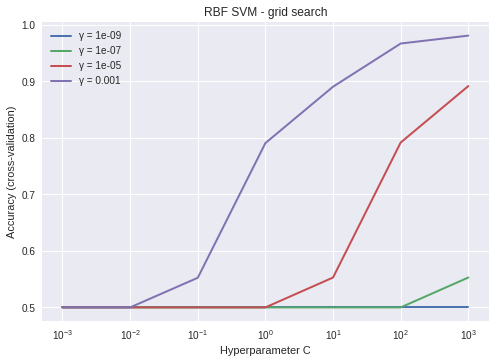

In [19]:
# ~-----RBF SVM-----
# auxiliary variables
accuracy_validation = np.zeros((C_range.shape[0], gamma_range.shape[0]))
score_max = 0
C_best_rbf = 0
gamma_best_rbf = 0


# optimizes parameters
print("============ RBF SVM ============")
for i,C in enumerate(C_range):
  for j,gamma in enumerate(gamma_range):
    model = svm.SVC(kernel='rbf', gamma=gamma, C=C)
    scores = cross_val_score(model, X_train, y_train, cv=10)
    avg = np.mean(scores)
    accuracy_validation[i][j] = avg
    print("C=" + str(C) + "   \tgamma=" + str(gamma) + "   \t--> %.2f%%" % (avg*100))
    if (avg > score_max):
        score_max = avg
        C_best_rbf = C
        gamma_best_rbf = gamma


# ~-----create best SVM-----
# train model
svc_rbf = svm.SVC(kernel='rbf', gamma=gamma_best_rbf, C=C_best_rbf)
svc_rbf.fit(X_train, y_train)

# evaluate classificator on testing set
accuracy = svc_rbf.score(X_test, y_test)


# ~-----visualize results-----
# validation accuracy
print('\n')
header = 'C\gamma   \t'
for gamma in gamma_range:
  header = header + str(gamma) + '\t'
print (header)
for i,C in enumerate(C_range):
  line = str(C) + '      \t'
  for j,gamma in enumerate(gamma_range):
    line = line + '%.2f%%' % (accuracy_validation[i][j]*100) + '\t'
  print(line)

# final accuracy
print("\nBest C=   \t" + str(C_best_rbf))
print("Best gamma= \t" + str(gamma_best_rbf))
print("Test accuracy= \t%.2f%%" % (accuracy*100))

# accuracy w.r.t. parameters
fig = plt.figure()
ax = fig.gca()
for i,gamma in enumerate(gamma_range):
  plt.plot(C_range, accuracy_validation[:,i], linewidth=2, label='γ = ' + str(gamma))
plt.xscale("log")
plt.title('RBF SVM - grid search')
plt.xlabel('Hyperparameter C')
plt.ylabel('Accuracy (cross-validation)')
ax.legend()

plt.show()

In [20]:
# ~-----RBF SVM-----

# heat map
trace = go.Heatmap(
    z = accuracy_validation,
    colorscale = "Blues",
    reversescale = True
)
layout = go.Layout(
    title = "RBF SVM - grid search",
    xaxis = dict(
        tickmode = "array",
        tickvals = np.linspace(0, len(gamma_range), num = len(gamma_range) + 1),
        ticktext = np.array(["1e-9", "1e-7", "1e-5", "1e-3"]),
        title = "Hyperparameter γ"
    ),
    yaxis = dict(
        tickmode = "array",
        tickvals = np.linspace(0, len(C_range), num = len(C_range) + 1),
        ticktext = ["0.001", "0.01", "0.1", "1", "10", "100", "1000"],
        title = "Hyperparameter C"
    )
)

data = [trace]
figure = go.Figure(data = data, layout = layout)
enable_plotly_in_cell()
plotly.offline.iplot(figure, filename="rbfAccuracy")

In [21]:
# ~-----confusion matrix-----
# compute confusion matrix
y_pred = svc_rbf.predict(X_test)
conf_mtx = confusion_matrix(y_test, y_pred)

# plot confusion matrix
for j in range(3):
  conf_mtx[0][j], conf_mtx[2][j] = conf_mtx[2][j], conf_mtx[0][j]
conf_mtx = np.ndarray.round(conf_mtx.astype(float) / conf_mtx.sum(axis = 1)[:, np.newaxis], 3)

cmColorScale = [[0.0, "rgb(255, 255, 255)"], [1.0, "rgb(0, 0, 255)"]]

z = conf_mtx
x = ["Galaxy", "QSO", "Star"]
y = ["Star", "QSO", "Galaxy"]
figure = ff.create_annotated_heatmap(z, x = x, y = y, colorscale= cmColorScale, showscale = True)
figure['layout']['xaxis']['title']['text'] = "Predicted Label"
figure['layout']['xaxis']['side'] = "bottom"
figure['layout']['yaxis']['title']['text'] = "True Label"
figure['layout']['title'] = "RBF SVM - confusion matrix"
enable_plotly_in_cell()
plotly.offline.iplot(figure, filename="rbfAccuracy") 

In [22]:
# ~-----sigmoid SVM-----
# useful libraries
from sklearn.model_selection import GridSearchCV


# auxiliary variables
accuracy_validation = np.zeros((C_range.shape[0], gamma_range.shape[0]))
score_max = 0
C_best_rbf = 0
gamma_best_rbf = 0
coef0_best = 0


# ~-----optimizes parameters-----
print("============ SIGMOID SVM ============")
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[1e-9, 1e-7, 1e-5, 1e-3]}
              #'coef0':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]} #coef0_best=0
model = svm.SVC(kernel='sigmoid')
svm_sigmoid = GridSearchCV(model, parameters, cv=10, return_train_score = False)
svm_sigmoid.fit(X_train, y_train)

# visualize overall accuracy
accuracy = svm_sigmoid.score(X_test, y_test)
print("Test accuracy= \t%.2f%%" % (accuracy*100))


# ~-----visualize parameters-----
result = pd.DataFrame(svm_sigmoid.cv_results_)
result.sort_values(by = ["rank_test_score"], axis = 0).head(1)

============ SIGMOID SVM ============
Test accuracy= 	97.47%


,mean_fit_time,mean_score_time,mean_test_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,std_fit_time,std_score_time,std_test_score
27,0.551482,0.019779,0.976429,1000,0.001,"{'C': 1000, 'gamma': 0.001}",1,0.975783,0.972896,0.96719,0.978602,0.978571,0.974249,0.97568,0.987124,0.974249,0.979971,0.019189,0.000173,0.004945


In [24]:
# ~-----confusion matrix-----
# compute confusion matrix
y_pred = svm_sigmoid.predict(X_test)
conf_mtx = confusion_matrix(y_test, y_pred)

# plot confusion matrix
for j in range(3):
  conf_mtx[0][j], conf_mtx[2][j] = conf_mtx[2][j], conf_mtx[0][j]
conf_mtx = np.ndarray.round(conf_mtx.astype(float) / conf_mtx.sum(axis = 1)[:, np.newaxis], 3)

cmColorScale = [[0.0, "rgb(255, 255, 255)"], [1.0, "rgb(0, 0, 255)"]]

z = conf_mtx
x = ["Galaxy", "QSO", "Star"]
y = ["Star", "QSO", "Galaxy"]
figure = ff.create_annotated_heatmap(z, x = x, y = y, colorscale= cmColorScale, showscale = True)
figure['layout']['xaxis']['title']['text'] = "Predicted Label"
figure['layout']['xaxis']['side'] = "bottom"
figure['layout']['yaxis']['title']['text'] = "True Label"
figure['layout']['title'] = "RBF SVM - confusion matrix"
enable_plotly_in_cell()
plotly.offline.iplot(figure, filename="rbfAccuracy") 

In [26]:
# ~-----poly SVM-----
# useful libraries
from sklearn.model_selection import GridSearchCV


# auxiliary variables
accuracy_validation = np.zeros((C_range.shape[0], gamma_range.shape[0]))
score_max = 0
C_best_rbf = 0
gamma_best_rbf = 0
coef0_best = 0
degree_best = 0


# ~-----optimizes parameters-----
print("============ POLY SVM ============")
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[1e-9, 1e-7, 1e-5, 1e-3],
              'degree':[2, 3, 4, 5]}
              #'coef0':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
model = svm.SVC(kernel='poly')
svm_poly = GridSearchCV(model, parameters, cv=10, return_train_score = False)
svm_poly.fit(X_train, y_train)

# visualize overall accuracy
accuracy = svm_poly.score(X_test, y_test)
print("Test accuracy= \t%.2f%%" % (accuracy*100))


# ~-----visualize parameters-----
result = pd.DataFrame(svm_poly.cv_results_)
result.sort_values(by = ["rank_test_score"], axis = 0).head(1)

============ POLY SVM ============
Test accuracy= 	64.33%


,mean_fit_time,mean_score_time,mean_test_score,param_C,param_degree,param_gamma,params,rank_test_score,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,std_fit_time,std_score_time,std_test_score
99,0.865325,0.05012,0.639286,1000,2,0.001,"{'C': 1000, 'degree': 2, 'gamma': 0.001}",1,0.632479,0.627675,...,0.63766,0.665714,0.642346,0.626609,0.642346,0.656652,0.645207,0.009541,0.000328,0.013888


In [27]:
# ~-----confusion matrix-----
# compute confusion matrix
y_pred = svm_poly.predict(X_test)
conf_mtx = confusion_matrix(y_test, y_pred)

# plot confusion matrix
for j in range(3):
  conf_mtx[0][j], conf_mtx[2][j] = conf_mtx[2][j], conf_mtx[0][j]
conf_mtx = np.ndarray.round(conf_mtx.astype(float) / conf_mtx.sum(axis = 1)[:, np.newaxis], 3)

cmColorScale = [[0.0, "rgb(255, 255, 255)"], [1.0, "rgb(0, 0, 255)"]]

z = conf_mtx
x = ["Galaxy", "QSO", "Star"]
y = ["Star", "QSO", "Galaxy"]
figure = ff.create_annotated_heatmap(z, x = x, y = y, colorscale= cmColorScale, showscale = True)
figure['layout']['xaxis']['title']['text'] = "Predicted Label"
figure['layout']['xaxis']['side'] = "bottom"
figure['layout']['yaxis']['title']['text'] = "True Label"
figure['layout']['title'] = "Poly SVM - confusion matrix"
enable_plotly_in_cell()
plotly.offline.iplot(figure, filename="rbfAccuracy"

SyntaxError: ignored